In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from tqdm import tqdm


from full_dynamics import FullSimulation

### 1.1 Spinodal (Theory)

Theoretical stability boundary:

In [2]:
def d_s(rho):
    alpha = np.pi/2 -1
    beta = alpha*(2*alpha-1)/(2*alpha+1)
    return (1-rho)*(1-alpha*rho + beta*rho**2)

def d_s_prime(rho):
    alpha = np.pi/2 -1
    beta = alpha*(2*alpha-1)/(2*alpha+1)
    return -(alpha+1)+2*(alpha+beta)*rho -3*beta*rho**2

L=20.0
D_0 = 1.0
D_E = 1.0
l = np.sqrt(D_E/D_0)
omega = 2*np.pi/L

def a(phi):
    return -D_E*d_s(phi)*(omega)**2

def b(phi, Pe):
    return -np.sqrt(D_0*D_E)*Pe/2*1.0j*(omega)*d_s(phi)

def W(phi, Pe):
    W = np.array([
        [-D_E*(omega)**2, -np.sqrt(D_0*D_E)*Pe/2*1.0j*(omega)*(1-phi), 0, 0, 0, 0, 0, 0, 0, 0],
        [2*b(phi, Pe) - np.sqrt(D_0*D_E)*Pe*1.0j*omega*phi*d_s_prime(phi), a(phi)-1*D_0, b(phi, Pe), 0, 0, 0, 0, 0, 0, 0],
        [0, b(phi, Pe), a(phi) - 4*D_0, b(phi, Pe), 0, 0, 0, 0, 0, 0],
        [0, 0, b(phi, Pe), a(phi) - 9*D_0, b(phi, Pe), 0, 0, 0, 0, 0],
        [0, 0, 0, b(phi, Pe), a(phi) - 16*D_0, b(phi, Pe), 0, 0, 0, 0],
        [0, 0, 0, 0, b(phi, Pe), a(phi) - 25*D_0, b(phi, Pe), 0, 0, 0],
        [0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 36*D_0, b(phi, Pe), 0, 0],
        [0, 0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 49*D_0, b(phi, Pe), 0],
        [0, 0, 0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 64*D_0, b(phi, Pe)],
        [0, 0, 0, 0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 81*D_0]
    ])
    return W

def stability(phi, Pe):
    W_ = W(phi, Pe)
    eigenvalues = np.linalg.eigvals(W_)
    largest_real_part = np.max(eigenvalues.real)
    if largest_real_part >= 0.0:
        return 0.0
    else:
        return 1.0

N_phi = 100
N_Pe = 100
stability_picture = np.array([[stability(phi, Pe) for phi in np.linspace(0, 1, N_phi)] for Pe in np.linspace(0, 40, N_Pe)])

stability_boundary = []
for i in range(stability_picture.shape[1]):
    column = stability_picture[:, i]
    change_indices = np.where(np.diff(column) != 0)[0]
    if len(change_indices) > 0:
        stability_boundary.append((i / N_phi, change_indices[0] * 40/ N_Pe))
stability_boundary = np.array(stability_boundary)


### 1.2 Spinodal (Experiment)

Experiment:

In [3]:
N_x = 200
N_theta = 30
stabilities = []
params = []

def maximal_instability_function(phi, Pe):
    W_ = W(phi, Pe)
    eigenvalues, eigenvectors = np.linalg.eig(W_)

    # Find the index of the eigenvalue with the largest real part
    index_max_real = np.argmax(eigenvalues.real)
    A_n = eigenvectors[:, index_max_real]

    def f_0(x, theta):
        eigenfunction = np.real(np.sum([A_n[k] * np.cos(k*theta) * np.exp(1.0j * 2*np.pi/20 * x) for k in range(10)]))
        return eigenfunction
    
    return f_0

for phi in tqdm(np.linspace(0.4, 0.99, 30)):
    for v_0 in np.concatenate((np.linspace(0.0, 10.0, 10), np.linspace(10.0, 30.0, 15))):

        #UNCOMMENT TO RUN SIMULATIONS
        '''
        #set up initial condiiton
        test_f = FullSimulation(N_x=N_x+2, N_theta = N_theta, v_0 = v_0, L_x = 20, epsilon = 0.0)
        delta_f = maximal_instability_function(phi, v_0)
        pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, N_theta)] for x in np.linspace(0, 20, N_x)])
        
        test_f.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((N_x, N_theta)) + 0.001*pertubation)

        #run sim
        end_time = 4.0
        test_f.evolve(end_time, show_progress=False)   
        initial_dist = np.sqrt(np.sum(np.square(test_f.history_rho[0][1:-1] - phi)))
        derivative = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - np.sqrt(np.sum(np.square(test_f.history_rho[-50][1:-1]  - phi))))
        val = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - initial_dist)

        if derivative*val >= 0.0:
            stabilities.append(val)
        else:
            stabilities.append(0.0)'''
        params.append([phi, v_0])

#np.save('stability', stabilities)
print(params)
params = np.array(params)
stability = np.load('data/stability.npy')

100%|██████████| 30/30 [00:00<00:00, 19343.45it/s]

[[np.float64(0.4), np.float64(0.0)], [np.float64(0.4), np.float64(1.1111111111111112)], [np.float64(0.4), np.float64(2.2222222222222223)], [np.float64(0.4), np.float64(3.3333333333333335)], [np.float64(0.4), np.float64(4.444444444444445)], [np.float64(0.4), np.float64(5.555555555555555)], [np.float64(0.4), np.float64(6.666666666666667)], [np.float64(0.4), np.float64(7.777777777777779)], [np.float64(0.4), np.float64(8.88888888888889)], [np.float64(0.4), np.float64(10.0)], [np.float64(0.4), np.float64(10.0)], [np.float64(0.4), np.float64(11.428571428571429)], [np.float64(0.4), np.float64(12.857142857142858)], [np.float64(0.4), np.float64(14.285714285714285)], [np.float64(0.4), np.float64(15.714285714285715)], [np.float64(0.4), np.float64(17.142857142857142)], [np.float64(0.4), np.float64(18.57142857142857)], [np.float64(0.4), np.float64(20.0)], [np.float64(0.4), np.float64(21.42857142857143)], [np.float64(0.4), np.float64(22.857142857142858)], [np.float64(0.4), np.float64(24.285714285714

### 1.3 Binodal (Experiment)

Experimental Binodal line: 

In [4]:
class GrCE_fullsim(FullSimulation):
    def update(self):
        self.f[0, :] = self.f[1, :]
        self.f[-1, :] = self.f[-2, :]
        
        a_x, a_theta, df_dt_ = self.df_dt()
        a_x = max(a_x, 0.1)
        a_theta = max(a_theta, 0.1)

        delta_t = min(self.delta_x / (a_x * self.CFL_factor), self.delta_theta / (a_theta * self.CFL_factor), self.dt_max)
        
        self.f[1:-1, :] += df_dt_ * delta_t
        return delta_t
    
def calculate_binodal(phi_0=0.6585, Pe=10.0, t_0 = 100.0, t_1 = 100.0, L_x1 = 20, L_x2 = 40, N_x = 200):
    N_theta = 30
    phi = phi_0
    v_0 = Pe

    binodal_sim = FullSimulation(N_x=N_x+2, N_theta = N_theta, v_0 = v_0, L_x = L_x1, epsilon = 0.0)
    delta_f = maximal_instability_function(phi, v_0)
    pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, N_theta)] for x in np.linspace(0, 20, N_x)])
    binodal_sim.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((N_x, N_theta)) + 0.01*pertubation)
    binodal_sim.evolve(t_0, show_progress=False)


    binodal_sim_2 = GrCE_fullsim(N_x=N_x+2, N_theta = N_theta, v_0 = v_0, L_x = L_x2, epsilon = 0.0)
    binodal_sim_2.f = np.copy(binodal_sim.f)
    binodal_sim_2.f[1:-1, :] = np.repeat(binodal_sim.f[1:N_x//2+1, :], 2, axis=0)
    binodal_sim_2.evolve(t_1, show_progress=False)
    
    return np.min(binodal_sim_2.history_rho[-1]), np.max(binodal_sim_2.history_rho[-1])

In [5]:
'''binodals = []
Pes = []
for Pe in np.concatenate(np.linspace(4.0, 7.0, 30), np.linspace(7.0, 30.0, 20)):

    RUN SIMULATION
    if Pe >= 15:
        N_x = 800
    else:
        N_x = 400
    vals = calculate_binodal(Pe = 8.0, L_x1 = 40, L_x2 = 80, N_x = N_x, t_0=200, t_1 = 200)
    #print(f'done Pe = {Pe}, values are {vals}')'

    #binodals.append(vals)
    Pes.append(Pe)'''


"binodals = []\nPes = []\nfor Pe in np.concatenate(np.linspace(4.0, 7.0, 30), np.linspace(7.0, 30.0, 20)):\n\n    RUN SIMULATION\n    if Pe >= 15:\n        N_x = 800\n    else:\n        N_x = 400\n    vals = calculate_binodal(Pe = 8.0, L_x1 = 40, L_x2 = 80, N_x = N_x, t_0=200, t_1 = 200)\n    #print(f'done Pe = {Pe}, values are {vals}')'\n\n    #binodals.append(vals)\n    Pes.append(Pe)"

convergence checks:

In [6]:
'''Ls_array = np.array([40, 50])
binodals = []
for L in tqdm(Ls_array):
    binodals.append(calculate_binodal(Pe = 10.0, L_x1 = L, L_x2 = 2*L, N_x = 400, t_0=200, t_1 = 200))
'''

'Ls_array = np.array([40, 50])\nbinodals = []\nfor L in tqdm(Ls_array):\n    binodals.append(calculate_binodal(Pe = 10.0, L_x1 = L, L_x2 = 2*L, N_x = 400, t_0=200, t_1 = 200))\n'

## 2: Figure Generation

/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_98811/2712014158.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(stability_boundary[:, 0], stability_boundary[:, 1], 'r', label = 'Spinodal (Theory)', color='black')


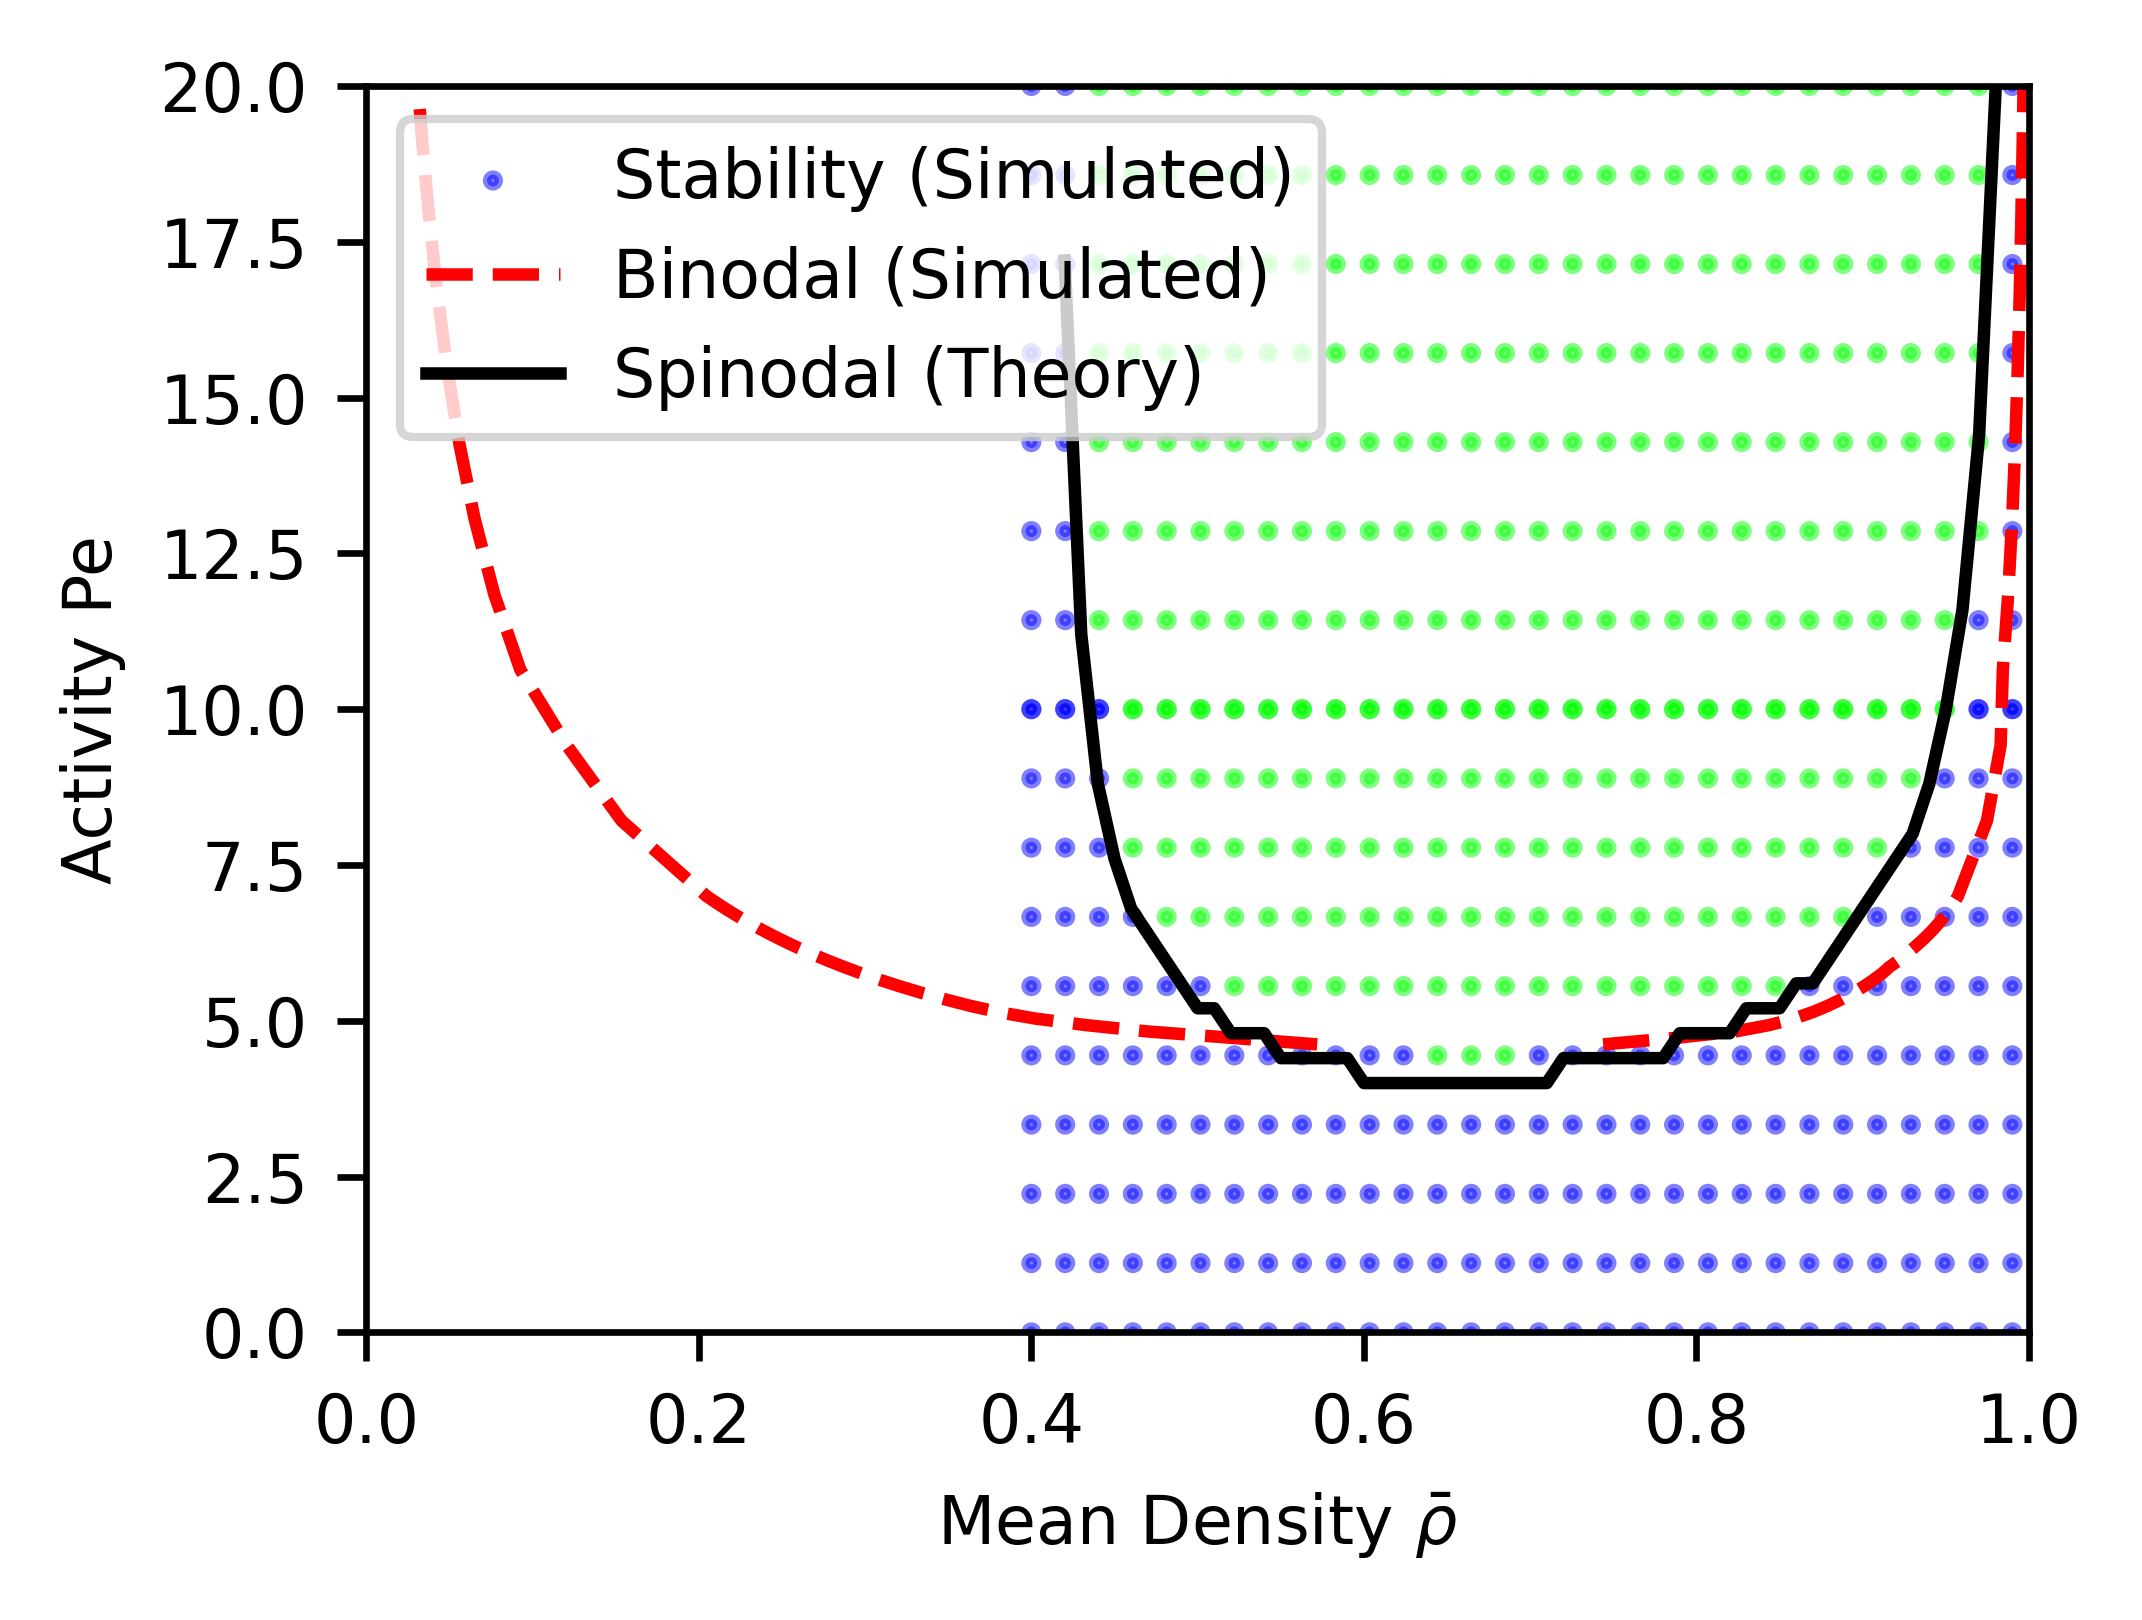

In [7]:
data = np.load('data/binodals_data.npz')
binodals = data['bins']
Pes = data['Pe']

sorted_indices = np.argsort(Pes)
PES = Pes[sorted_indices]
BINS = binodals[sorted_indices]

plt.figure(figsize=(3.37,2.5), dpi=600)
stabilities = np.load('data/stability.npy')
plt.scatter(params[:, 0], params[:, 1], c=stabilities, cmap='brg', label='Stability (Simulated)', s=2.0, alpha=.5)

fontsize = '8'

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 20)
plt.xlabel(r'Mean Density $\bar{\rho}$', fontsize="8")
plt.ylabel(r'Activity Pe', fontsize="8")
starting_index = 6
plt.plot(BINS[starting_index:, 0], PES[starting_index:], color='red', linestyle='--')
plt.plot(BINS[starting_index:, 1], PES[starting_index:], color='red', linestyle='--', label='Binodal (Simulated)')
#plt.scatter(BINS[starting_index:, 0], PES[starting_index:], color='red', s=10)
#plt.scatter(BINS[starting_index:, 1], PES[starting_index:], color='red', s=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.plot(stability_boundary[:, 0], stability_boundary[:, 1], 'r', label = 'Spinodal (Theory)', color='black')


plt.legend(loc='upper left', fontsize=8)
plt.tight_layout(pad=0.0)
#plt.savefig('fig1.pdf')
plt.show()